# Customer Segmentation Using KMeans (RFM Analysis)

A comprehensive customer analysis that applies K-means algorithms to customer data using three key 
features such as Frequency, Recency, and Monetary value (RFM) to group customers and understand their 
purchasing behavior based on these three key features. This helps the business conduct customer-centric 
marketing more effectively.

**About The Dataset**:

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

**Variable Information**:
- **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
- **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal. The name of the country where a customer resides.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



#settings to make numbers easier to read on display
pd.set_option('display.float_format', lambda x: "%.4f" %x)

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

### Prepare Data

#### Import

In [2]:
def wrangle(filepath:str):
    # Read file into dataframe
    df = pd.read_excel(filepath, sheet_name=0)

    return df

#### Explore

In [3]:
df = wrangle("online_retail_II.xlsx")
print(df.shape)
print(df.info())

(525461, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


In [8]:
# Statistiscal information
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.0000,525461,525461.0000,417534.0000
mean,10.3377,2010-06-28 11:37:36.845017856,4.6888,15360.6455
min,-9600.0000,2009-12-01 07:45:00,-53594.3600,12346.0000
25%,1.0000,2010-03-21 12:20:00,1.2500,13983.0000
50%,3.0000,2010-07-06 09:51:00,2.1000,15311.0000
75%,10.0000,2010-10-15 12:45:00,4.2100,16799.0000
max,19152.0000,2010-12-09 20:01:00,25111.0900,18287.0000
std,107.4241,NaN,146.1269,1680.8113


In [5]:
# check for missing value
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Things we need to deal wIth:
- Notice how Quantity and Price columns have negative value
- The id column has missing values

Looking at data where we have missing value

In [6]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0000,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0000,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0000,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0000,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.5500,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.8500,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.9500,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.2500,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.9500,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.6500,NaN,United Kingdom


Notice how rows with null "Customer Id" has prices with negative values, 0, or a value slightly greater than 0. We are going to remove cutomer_id rows with null values in our wrangle function.

**Looking at the rows with negative values for the quantity column**

In [7]:
print("shape: ", df[df["Quantity"] < 0].shape)
df[df["Quantity"] < 0].head()

shape:  (12326, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.9500,16321.0000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.6500,16321.0000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.2500,16321.0000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.1000,16321.0000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.9500,16321.0000,Australia


In [8]:
df[df["Quantity"] < 0]['Invoice'].str.replace("[0-9]", "", regex=True).value_counts()

Invoice
C    10205
Name: count, dtype: int64

In [9]:
# Using regex to find rows of Invoice that do not have 6 digits
df[df['Invoice'].str.match("^\\d{6}$") == False].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.9500,16321.0000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.6500,16321.0000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.2500,16321.0000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.1000,16321.0000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.9500,16321.0000,Australia


In [10]:
# Removing all numbers from the Invoice leaving us with letters and empty string
df['Invoice'] = df['Invoice'].astype(str)
df['Invoice'].str.replace("[0-9]", "", regex=True).value_counts()

Invoice
     515252
C     10206
A         3
Name: count, dtype: int64

In [11]:
# Checking how many of the Invoice id starts with A
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.3600,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.7900,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.8700,NaN,United Kingdom


In [12]:
# casting StockCode column to string type
df['StockCode'] = df['StockCode'].astype('str')

# using regex to find where rows of the StockCode doesn't match 5 digit
# and also contains other numbers and letters that are repeated
(df[(df['StockCode'].str.match('^\\d{5}$') == False) & 
    (df['StockCode'].str.match('^\\d{5}[a-zA-z]+$') == False)]['StockCode'].unique()
)

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

From the above data exploration on rows with negative quantity values, it was observed that most of them contain invoice id that starts with C which indicates cancellation as described in the data description section. Invoices that starts with the letter "A" has price value has negative and missing Customer_Id. Stock code that do not have 5 digits would also be filtered out.

In [9]:
# Creating a wrangle function
def wrangle(filepath:str):
    # Read file into dataframe
    df = pd.read_excel(filepath, sheet_name=0)

    # get only invoice number with 6-digits
    df['Invoice'] = df['Invoice'].astype('str')
    masked = df['Invoice'].str.match('^\\d{6}$')
    df = df[masked]

    # get stock code with five-digit or five-digits followed by letter(s)
    df['StockCode'] = df['StockCode'].astype('str')
    masked_stockcode = (
        (df['StockCode'].str.match("^\\d{5}$")) |
        (df['StockCode'].str.match("^\\d{5}[a-zA-Z]+$"))
    )

    # drop Customer_id with null values
    df.dropna(subset='Customer ID', inplace=True)

    # Getting dataset for only 2010
    df = df[df['InvoiceDate'] >= "2010-01-01"]

    return df

In [10]:
cleaned_df = wrangle("online_retail_II.xlsx")


In [11]:
print(cleaned_df.info())
cleaned_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 376934 entries, 45228 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      376934 non-null  object        
 1   StockCode    376934 non-null  object        
 2   Description  376934 non-null  object        
 3   Quantity     376934 non-null  int64         
 4   InvoiceDate  376934 non-null  datetime64[ns]
 5   Price        376934 non-null  float64       
 6   Customer ID  376934 non-null  float64       
 7   Country      376934 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 25.9+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5000,12346.0000,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.5000,12346.0000,United Kingdom
45234,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.5500,14590.0000,United Kingdom
45235,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28:00,4.2500,14590.0000,United Kingdom
45236,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28:00,2.5500,14590.0000,United Kingdom


In [12]:
# ou data is cleaned of negative values
cleaned_df.describe()[['Quantity', 'Price']]

,Quantity,Price
count,376934.0000,376934.0000
mean,13.6337,3.3022
min,1.0000,0.0000
25%,2.0000,1.2500
50%,5.0000,1.9500
75%,12.0000,3.7500
max,19152.0000,10953.5000
std,99.0329,36.0544


In [13]:
# The percentage of data after cleaning process
print("percentage of data after cleaning: ", round(len(cleaned_df)/len(df)*100,2))

percentage of data after cleaning:  71.73


#### Feature Engineering

In [14]:
cleaned_df["TotalSales"] = cleaned_df["Quantity"] * cleaned_df["Price"]
cleaned_df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5000,12346.0000,United Kingdom,22.5000
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.5000,12346.0000,United Kingdom,22.5000
45234,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.5500,14590.0000,United Kingdom,91.8000


Making aggregation base on customer ID in order to determine their recency, how frequent they buy product, and customer's monetary value.

In [15]:
aggregated_df = (cleaned_df.groupby(by='Customer ID', as_index=False)
                 .aggregate(
                     MonetaryValue=('TotalSales', 'sum'),
                     Frequency=('Invoice', 'nunique'),
                     LastInvoiceDate=('InvoiceDate', 'max'),
                     FirstInvoiceDate=("InvoiceDate", 'min')
                 )
)

In [16]:
aggregated_df.sort_values('Frequency', ascending=False).head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate
1801,14911.0000,145028.3300,196,2010-12-09 12:17:00,2010-01-07 19:34:00
3893,17850.0000,43797.7300,140,2010-12-02 15:27:00,2010-01-14 12:46:00
247,12748.0000,21028.1500,137,2010-12-09 13:22:00,2010-01-14 14:41:00
2084,15311.0000,46633.0200,107,2010-12-09 14:15:00,2010-01-05 15:29:00
494,13089.0000,54783.5300,104,2010-12-06 14:00:00,2010-01-10 12:47:00


In [17]:
# getting a benchmark for recency
max_invoice_date = aggregated_df['LastInvoiceDate'].max()
print(max_invoice_date)

2010-12-09 20:01:00


In [18]:
aggregated_df['Recency'] = (max_invoice_date - aggregated_df['LastInvoiceDate']).dt.days

In [19]:
print(aggregated_df.info())
aggregated_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201 entries, 0 to 4200
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Customer ID       4201 non-null   float64       
 1   MonetaryValue     4201 non-null   float64       
 2   Frequency         4201 non-null   int64         
 3   LastInvoiceDate   4201 non-null   datetime64[ns]
 4   FirstInvoiceDate  4201 non-null   datetime64[ns]
 5   Recency           4201 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 197.1 KB
None


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency
0,12346.0000,259.3600,6,2010-06-28 13:53:00,2010-01-04 09:24:00,164
1,12347.0000,1323.3200,2,2010-12-07 14:57:00,2010-10-31 14:20:00,2
2,12348.0000,222.1600,1,2010-09-27 14:59:00,2010-09-27 14:59:00,73
3,12349.0000,2671.1400,3,2010-10-28 08:23:00,2010-04-29 13:20:00,42
4,12351.0000,300.9300,1,2010-11-29 15:23:00,2010-11-29 15:23:00,10


In [20]:
aggregated_df["StartQaurter"] = aggregated_df['FirstInvoiceDate'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:"Q4"})
aggregated_df["LastQaurter"] = aggregated_df['LastInvoiceDate'].dt.quarter.map({1:'Q1', 2:'Q2', 3:'Q3', 4:"Q4"})


In [21]:
df.shape

(525461, 8)

In [22]:
aggregated_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency,StartQaurter,LastQaurter
0,12346.0000,259.3600,6,2010-06-28 13:53:00,2010-01-04 09:24:00,164,Q1,Q2
1,12347.0000,1323.3200,2,2010-12-07 14:57:00,2010-10-31 14:20:00,2,Q4,Q4
2,12348.0000,222.1600,1,2010-09-27 14:59:00,2010-09-27 14:59:00,73,Q3,Q3
3,12349.0000,2671.1400,3,2010-10-28 08:23:00,2010-04-29 13:20:00,42,Q2,Q4
4,12351.0000,300.9300,1,2010-11-29 15:23:00,2010-11-29 15:23:00,10,Q4,Q4


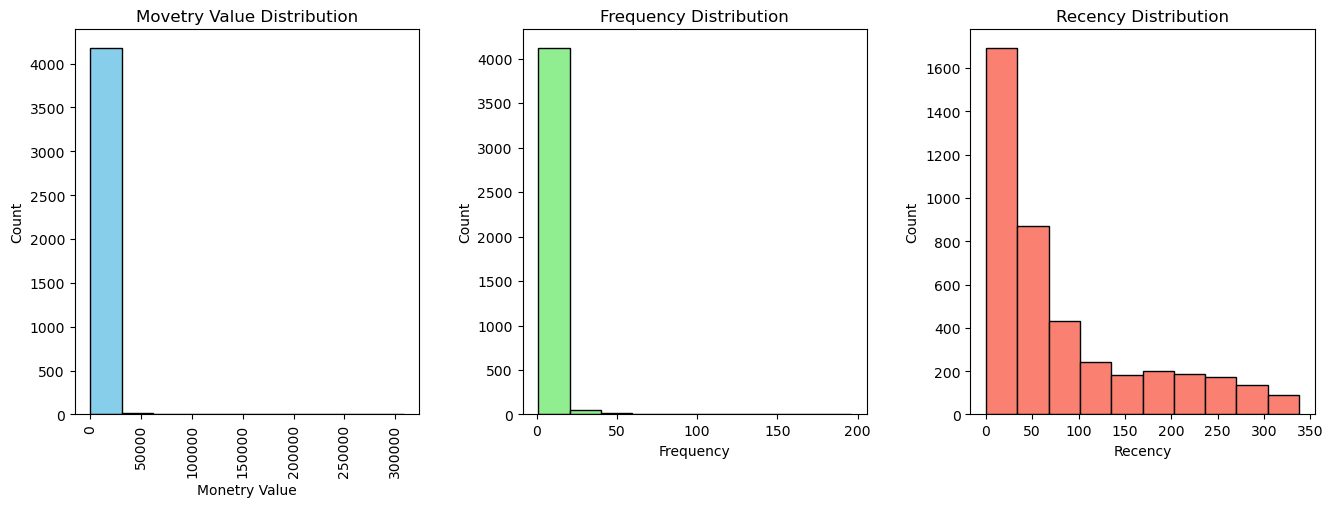

In [23]:
plt.figure(figsize=(16, 5))

plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Movetry Value Distribution')
plt.xlabel('Monetry Value')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist(aggregated_df['Recency'], bins=10, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.show()

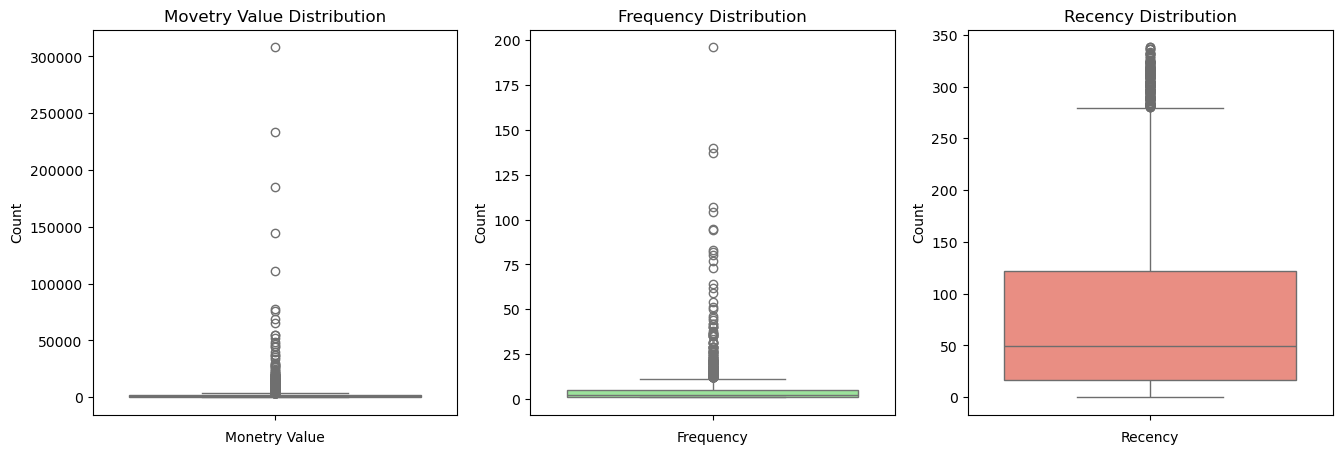

In [24]:
# using boxplot to see outliers
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Movetry Value Distribution')
plt.xlabel('Monetry Value')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.boxplot(aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.boxplot(aggregated_df['Recency'], color='salmon')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.show()

In [25]:
# getting the first and second quartile for monetary dataset
M_Q1, M_Q3 = aggregated_df['MonetaryValue'].quantile([0.25, 0.75])

# getting the interquartile range (IQR) for monetary dataset
M_IQR = M_Q3 - M_Q1
M_lb, M_ub = round((M_Q1 - 1.5*M_IQR), 2), round((M_Q3 + 1.5*M_IQR), 2)

# getting data points where meanetary values are considered outliers
Monetary_outlier_df = (
    aggregated_df[aggregated_df['MonetaryValue'] 
    .between(M_lb, M_ub) == False]
)
Monetary_outlier_df.describe()


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency
count,399.0000,399.0000,399.0000,399,399,399.0000
mean,15063.0025,11888.0031,16.3810,2010-11-10 23:14:44.661654272,2010-02-22 04:11:51.428571392,28.5840
min,12357.0000,3686.6100,1.0000,2010-02-23 15:17:00,2010-01-04 11:15:00,0.0000
25%,13570.0000,4512.3450,7.0000,2010-11-08 09:51:00,2010-01-13 10:32:00,3.0000
50%,14952.0000,6116.9200,11.0000,2010-11-26 11:50:00,2010-01-29 12:52:00,13.0000
75%,16557.0000,9996.0800,17.5000,2010-12-06 09:48:30,2010-03-08 13:42:30,31.0000
max,18260.0000,308158.6100,196.0000,2010-12-09 19:32:00,2010-11-16 10:05:00,289.0000
std,1741.2345,24482.6194,19.5179,NaN,NaN,45.4076


In [26]:
# getting the first and second quartile for frequency dataset

F_Q1, F_Q3 = aggregated_df['Frequency'].quantile([0.25, 0.75])

# getting the interquartile range (IQR) for monetary dataset
F_IQR = F_Q3 - F_Q1

# getting the lower and upper bound for frequency dataset
F_lb, F_ub = round((F_Q1 - 1.5*F_IQR), 2), round((F_Q3 + 1.5*F_IQR), 2)

# getting data points where frequency are considered outliers
Frequency_outlier_df = (
    aggregated_df[aggregated_df['Frequency'] 
    .between(F_lb, F_ub) == False]
)

Frequency_outlier_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency
count,247.0000,247.0000,247.0000,247,247,247.0000
mean,15339.6761,14449.0458,23.6478,2010-11-23 09:31:37.165991936,2010-02-06 21:37:45.910931200,16.1498
min,12422.0000,955.7700,12.0000,2010-05-12 16:51:00,2010-01-04 10:28:00,0.0000
25%,13772.0000,4152.5050,13.0000,2010-11-19 15:09:00,2010-01-10 13:19:00,2.0000
50%,15498.0000,6505.6200,16.0000,2010-12-02 13:08:00,2010-01-21 14:30:00,7.0000
75%,16901.0000,12723.3350,23.0000,2010-12-07 11:57:00,2010-02-17 15:43:30,20.0000
max,18260.0000,308158.6100,196.0000,2010-12-09 19:32:00,2010-08-19 15:28:00,211.0000
std,1778.6704,30611.2929,22.2009,NaN,NaN,27.0718


In [27]:
non_outlier_df = aggregated_df[
    (~aggregated_df.index.isin(Monetary_outlier_df.index)) \
    & (~aggregated_df.index.isin(Frequency_outlier_df.index))
    ]
non_outlier_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency
count,3752.0000,3752.0000,3752.0000,3752,3752,3752.0000
mean,15365.6255,872.3074,2.7814,2010-09-11 02:40:03.997867520,2010-06-02 21:01:18.486140928,89.4419
min,12346.0000,0.0000,1.0000,2010-01-05 12:43:00,2010-01-04 09:24:00,0.0000
25%,13899.5000,277.8175,1.0000,2010-07-25 12:48:30,2010-03-01 16:22:15,21.0000
50%,15369.0000,582.4050,2.0000,2010-10-14 16:47:00,2010-05-12 12:25:00,56.0000
75%,16838.5000,1248.4350,4.0000,2010-11-18 11:43:45,2010-09-17 15:32:15,137.0000
max,18287.0000,3681.0300,11.0000,2010-12-09 20:01:00,2010-12-09 16:08:00,338.0000
std,1695.5270,802.1064,2.1696,NaN,NaN,88.5181


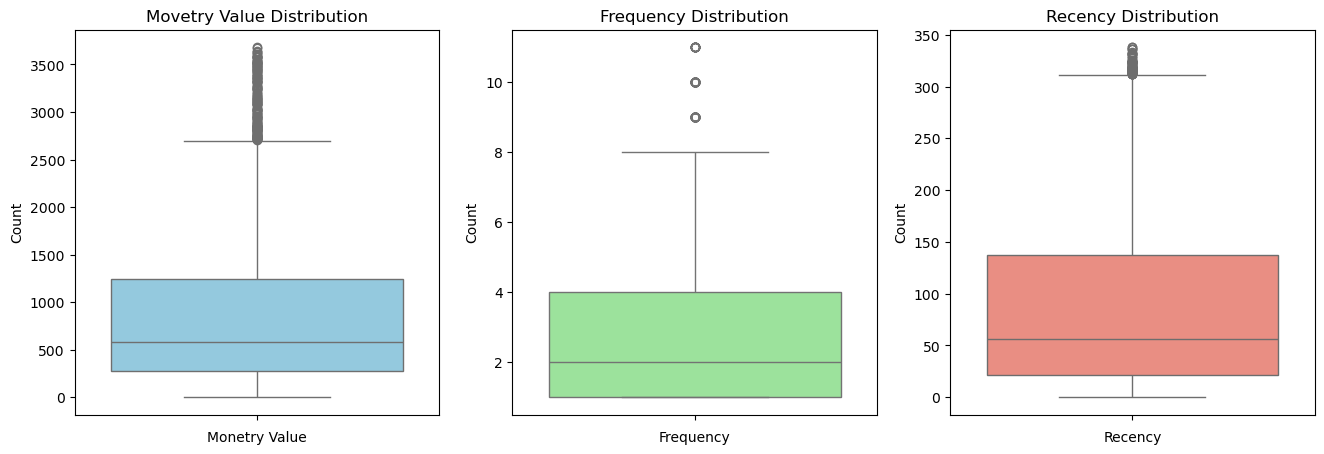

In [28]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(non_outlier_df['MonetaryValue'], color='skyblue')
plt.title('Movetry Value Distribution')
plt.xlabel('Monetry Value')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.boxplot(non_outlier_df['Frequency'], color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.boxplot(non_outlier_df['Recency'], color='salmon')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.show()

The outliers have been reduced to bearable minimum

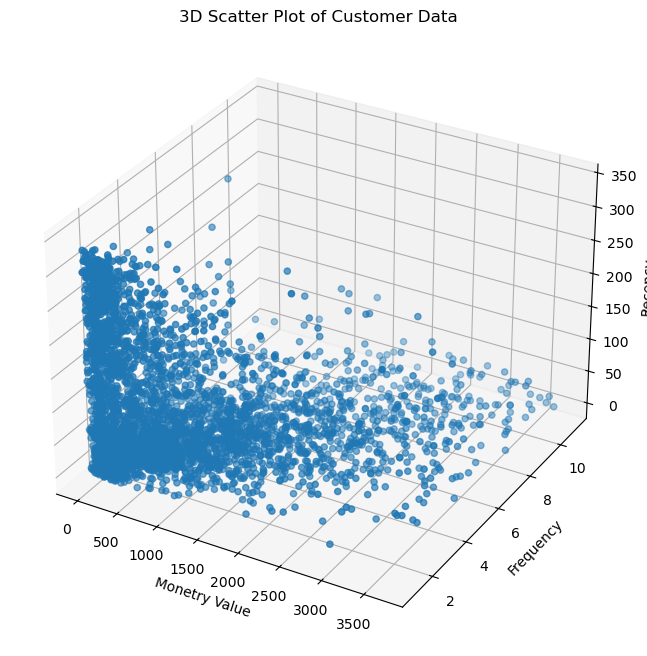

In [29]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(projection="3d")
scatter = ax.scatter(
    non_outlier_df['MonetaryValue'], 
    non_outlier_df['Frequency'],
    non_outlier_df['Recency']
    )
ax.set_xlabel('Monetry Value')
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
plt.title("3D Scatter Plot of Customer Data")
plt.show()

In [30]:
scaler = StandardScaler()

scaled_df = scaler.fit_transform(non_outlier_df[['MonetaryValue', 'Frequency', 'Recency']])
scaled_df

array([[-0.764274  ,  1.48366492,  0.84240459],
       [ 0.56236021, -0.36022735, -0.98797386],
       [-0.81065806, -0.82120042, -0.18577096],
       ...,
       [-0.55524644, -0.82120042,  2.32252543],
       [-0.04841322, -0.82120042,  0.24357707],
       [ 1.83716147,  0.56171878, -0.81849437]])

In [31]:
scaled_df = pd.DataFrame(scaled_df, index=non_outlier_df.index, columns=['MonetaryValue', 'Frequency', 'Recency'])
scaled_df.head()

,MonetaryValue,Frequency,Recency
0,-0.7643,1.4837,0.8424
1,0.5624,-0.3602,-0.9880
2,-0.8107,-0.8212,-0.1858
3,2.2429,0.1007,-0.5360
4,-0.7124,-0.8212,-0.8976


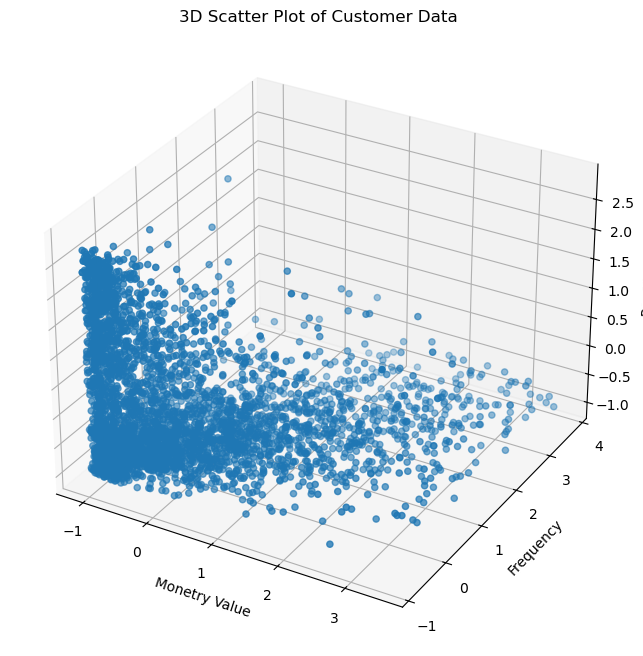

In [32]:
# showing that only the scale of our data has change, every other things are the same
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(projection="3d")
scatter = ax.scatter(
    scaled_df['MonetaryValue'], 
    scaled_df['Frequency'],
    scaled_df['Recency']
    )
ax.set_xlabel('Monetry Value')
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
plt.title("3D Scatter Plot of Customer Data")
plt.show()

## Building The Model

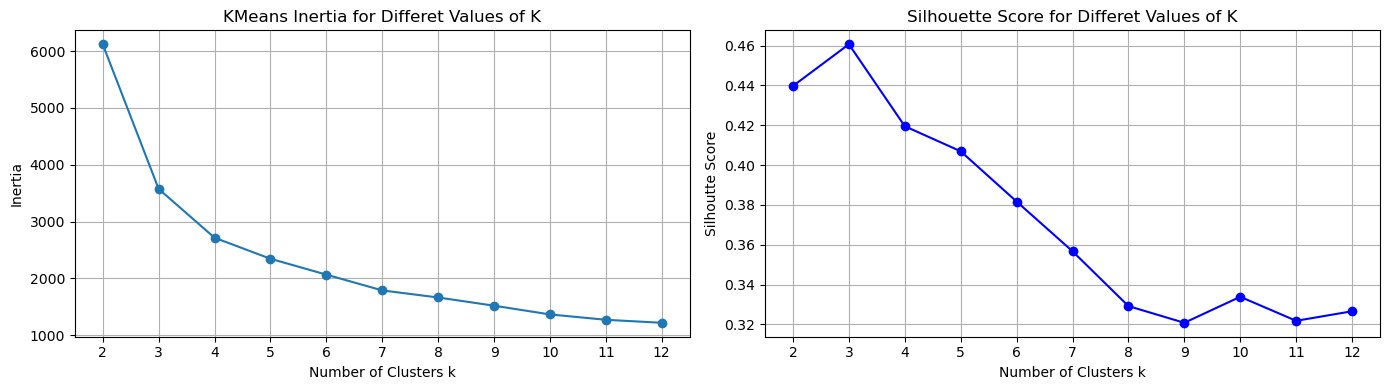

In [33]:
# finding best k_value
k_max = 12

inertia = []
silhouette_scores = []
k_values = range(2, k_max +1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    
    # getting labels
    cluster_labels = kmeans.fit_predict(scaled_df)
    
    #computing the silhouette_score for each labels
    sil_score = silhouette_score(scaled_df, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Differet Values of K')
plt.xlabel('Number of Clusters k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, marker='o', color='blue')
plt.title('Silhouette Score for Differet Values of K')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhoutte Score')
plt.xticks(k_values)

plt.tight_layout()
plt.grid(True)
plt.show()

Four clusters appear to be the best number of clusters to use

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_df)

cluster_labels[:6]

array([0, 0, 1, 0, 1, 1])

In [35]:
non_outlier_df['Cluster'] = cluster_labels

non_outlier_df.head(6)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate,Recency,StartQaurter,LastQaurter,Cluster
0,12346.0000,259.3600,6,2010-06-28 13:53:00,2010-01-04 09:24:00,164,Q1,Q2,0
1,12347.0000,1323.3200,2,2010-12-07 14:57:00,2010-10-31 14:20:00,2,Q4,Q4,0
2,12348.0000,222.1600,1,2010-09-27 14:59:00,2010-09-27 14:59:00,73,Q3,Q3,1
3,12349.0000,2671.1400,3,2010-10-28 08:23:00,2010-04-29 13:20:00,42,Q2,Q4,0
4,12351.0000,300.9300,1,2010-11-29 15:23:00,2010-11-29 15:23:00,10,Q4,Q4,1
5,12352.0000,343.8000,2,2010-11-29 10:07:00,2010-11-12 10:20:00,10,Q4,Q4,1


In [36]:
non_outlier_df.dtypes

Customer ID                float64
MonetaryValue              float64
Frequency                    int64
LastInvoiceDate     datetime64[ns]
FirstInvoiceDate    datetime64[ns]
Recency                      int64
StartQaurter                object
LastQaurter                 object
Cluster                      int32
dtype: object

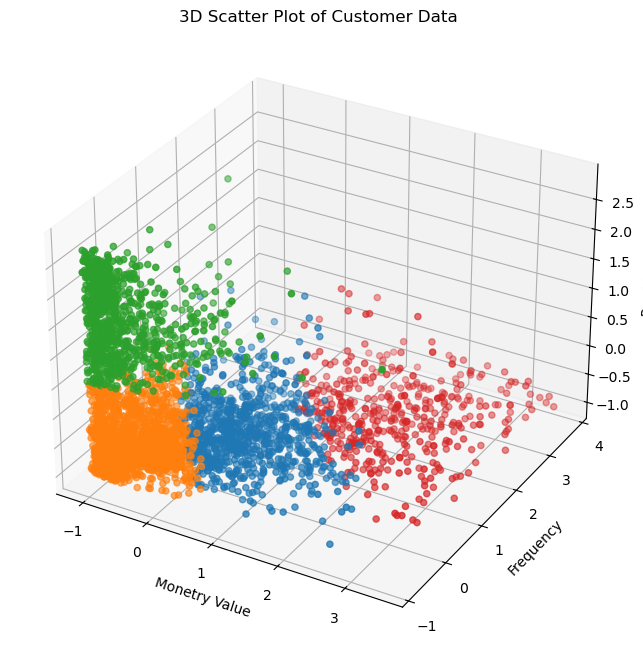

In [37]:
color_clusters = {
    0: '#1f77b4', # blue
    1: '#ff7f0e', # orange
    2: '#2ca02c', # green
    3: '#d62728', # red
    }

colors = non_outlier_df['Cluster'].map(color_clusters)

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(projection="3d")
scatter = ax.scatter(
    scaled_df['MonetaryValue'], 
    scaled_df['Frequency'],
    scaled_df['Recency'],
    c = colors,
    marker='o'
    )
ax.set_xlabel('Monetry Value')
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
plt.title("3D Scatter Plot of Customer Data")
plt.show()

## Interpreting 

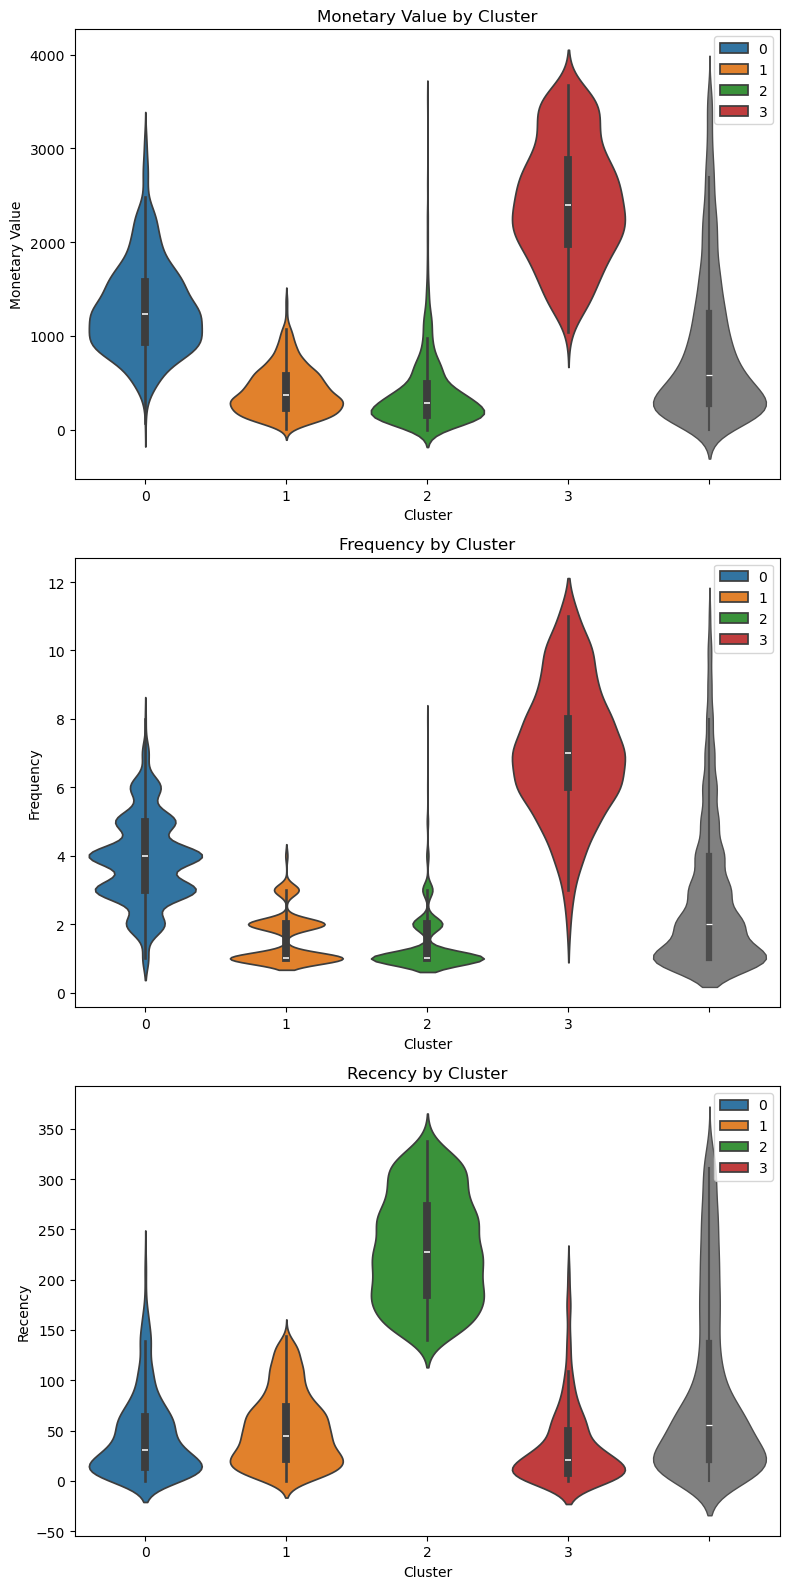

In [38]:
%matplotlib inline
plt.figure(figsize=(8, 16))
plt.subplot(3,1,1)
sns.violinplot(x=non_outlier_df['Cluster'], y=non_outlier_df['MonetaryValue'], palette=color_clusters, hue=non_outlier_df['Cluster'])
sns.violinplot(y=non_outlier_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title("Monetary Value by Cluster")
plt.ylabel("Monetary Value")

plt.subplot(3,1,2)
sns.violinplot(x=non_outlier_df['Cluster'], y=non_outlier_df['Frequency'], palette=color_clusters, hue=non_outlier_df['Cluster'])
sns.violinplot(y=non_outlier_df['Frequency'], color='gray', linewidth=1.0)
plt.title("Frequency by Cluster")
plt.ylabel("Frequency")

plt.subplot(3,1,3)
sns.violinplot(x=non_outlier_df['Cluster'], y=non_outlier_df['Recency'], palette=color_clusters, hue=non_outlier_df['Cluster'])
sns.violinplot(y=non_outlier_df['Recency'], color='gray', linewidth=1.0)
plt.title("Recency by Cluster")
plt.ylabel("Recency")

plt.tight_layout()
plt.show()

1. Cluster 0 (Blue): This cluster include customers with high monetary value, freqeunt buyers, and many of them have recently purchased. These are high-value customers and most loyal customer. Implement a loyalty program which provides exclusive offers to complement thier loyalty to keep them angaged and satisfied.
2. Cluster 1 (Orange): These cluster includes low monetary-value customers, who are infrequent but many have recently purchased. These customers may be new, providing excellent customer service, and offering incentives would encourage more frequent purchases.
3. Cluster 2 (Green): These Cluster represent high-monetary value customers who are frequent buyers, and recent buyers. These group are second most valuable customers. Focus on retaining customers in this group and maintain thier loyalty.
4. Cluster 3 (red): This cluster is a grooup ofmcustomers with the lowest monetary-value, who don't purchase frequently, and havn't recently made purchases. The focus is to re-engage these customers to bring them back into active purchasing behavior.

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   RFM-Analysis.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   RFM-Analysis.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.gitignore
	New Text Document.txt

